In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from torchvision.models import ResNet50_Weights
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def emotion_detector(data_dir, optimizer_name='adam', epochs=10, batch_size=32, learning_rate=0.001, save_path="model.pth"):
    
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data preprocessing
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),   
        transforms.RandomRotation(15),            
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomResizedCrop(256, scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_labels = [label for _, label in train_dataset]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) 
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False 

    num_classes = len(dataset.classes)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.Linear(512, 256),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")
    
    # Training the model
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")   

    # Plot training and validation losses
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure()
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Testing the model
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # AUC-ROC Curve
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            probs = torch.softmax(model(images), dim=1).cpu().numpy()
            all_probs.extend(probs)
    
    all_probs = np.array(all_probs)
    fpr, tpr, _ = roc_curve(np.eye(num_classes)[all_labels].ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return model

c:\Users\user\miniconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/40], Train Loss: 0.6910, Train Accuracy: 0.5501, Validation Loss: 0.6733, Validation Accuracy: 0.6386
Epoch [2/40], Train Loss: 0.6202, Train Accuracy: 0.6835, Validation Loss: 0.5505, Validation Accuracy: 0.7456
Epoch [3/40], Train Loss: 0.5358, Train Accuracy: 0.7645, Validation Loss: 0.5291, Validation Accuracy: 0.7293
Epoch [4/40], Train Loss: 0.4941, Train Accuracy: 0.8019, Validation Loss: 0.4607, Validation Accuracy: 0.8526
Epoch [5/40], Train Loss: 0.4685, Train Accuracy: 0.8267, Validation Loss: 0.4476, Validation Accuracy: 0.8264
Epoch [6/40], Train Loss: 0.4520, Train Accuracy: 0.8372, Validation Loss: 0.4926, Validation Accuracy: 0.8292
Epoch [7/40], Train Loss: 0.4412, Train Accuracy: 0.8493, Validation Loss: 0.4306, Validation Accuracy: 0.8533
Epoch [8/40], Train Loss: 0.4270, Train Accuracy: 0.8622, Validation Loss: 0.4303, Validation Accuracy: 0.8731
Epoch [9/40], Train Loss: 0.4204, Train Accuracy: 0.8652, Validation Loss: 0.4549, Validation Accuracy: 0.8639
E

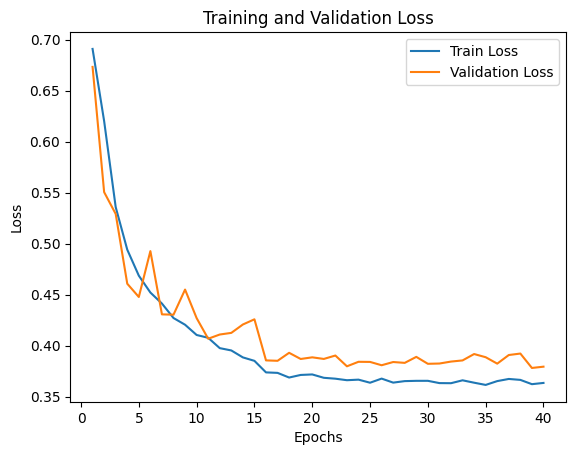

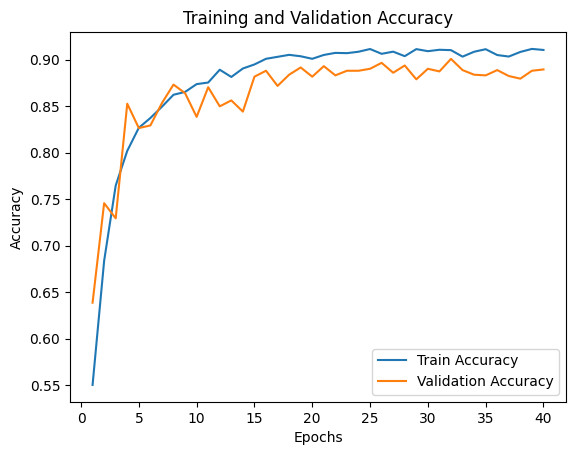


Classification Report:

              precision    recall  f1-score   support

      Senang       0.94      0.87      0.90      1793
       Takut       0.80      0.91      0.85      1029

    accuracy                           0.88      2822
   macro avg       0.87      0.89      0.88      2822
weighted avg       0.89      0.88      0.88      2822



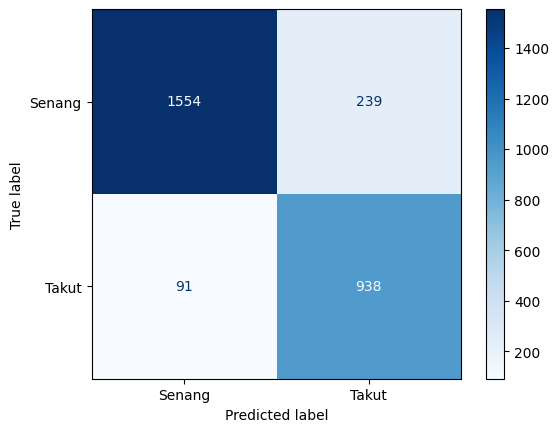

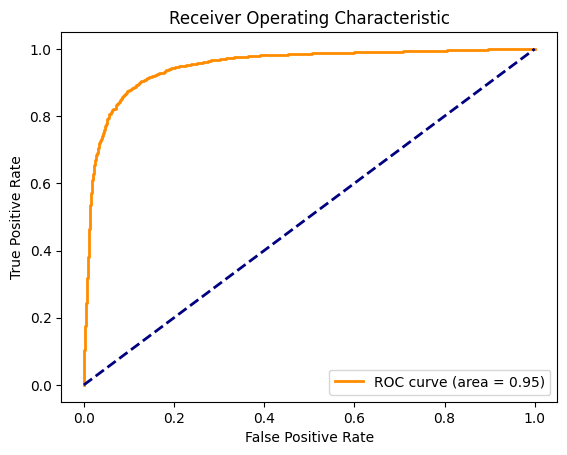

In [43]:
data_dir = 'E:/Skripsi/EmotionDetector.ipynb/Dataset Skripsi'

# Jalankan fungsi dengan parameter yang diinginkan
model = emotion_detector(
    data_dir=data_dir,
    optimizer_name='sgd',
    epochs=40,         # Jumlah epoch
    batch_size=16,     # Ukuran batch
    learning_rate=0.001,  # Learning rate
    save_path="resnet_emotion_model17.pth"
)